In [1]:
import pandas as pd
import numpy as np
import string
import re

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer as tfi
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [2]:
data = pd.read_csv('data/twitter_data/galaxys_edge.csv', 
                       usecols = ['tweet', 'date'])

data.head(20)

,date,tweet
0,2020-07-15,"Radio Batuu broadcasts Star Wars music, news a..."
1,2020-07-15,Entrance to Rise of the Resistance at 10:30am....
2,2020-07-15,The moment I saw this my mouth dropped open an...
3,2020-07-15,4 months later and this hunk of junk is still ...
4,2020-07-15,Headed to #GalaxysEdge this morning for the #d...
5,2020-07-15,"🤔A ""Woke"" @StarWars reboot? @Disney #Lucasfilm..."
6,2020-07-15,"Chewie, we’re home.\n\n#dvcrental #disneyvacat..."
7,2020-07-14,"2 years ago this week, this model for Star War..."
8,2020-07-14,"So...Ms. Oga's getting her cut of this, right ..."
9,2020-07-14,I wish I was back here. I went to the opening ...


In [3]:
print('before:', data.shape)

data.loc[data.astype(str).drop_duplicates().index]

print('after:', data.shape)

before: (43158, 2)
after: (43158, 2)


In [4]:
data['date'] = pd.to_datetime(data['date'])

data.head()

,date,tweet
0,2020-07-15,"Radio Batuu broadcasts Star Wars music, news a..."
1,2020-07-15,Entrance to Rise of the Resistance at 10:30am....
2,2020-07-15,The moment I saw this my mouth dropped open an...
3,2020-07-15,4 months later and this hunk of junk is still ...
4,2020-07-15,Headed to #GalaxysEdge this morning for the #d...


In [5]:
data.dtypes

date     datetime64[ns]
tweet            object
dtype: object

In [6]:
data['tweet'] = [text.lower() for text in data['tweet']]

print(data['tweet'])

0        radio batuu broadcasts star wars music, news a...
1        entrance to rise of the resistance at 10:30am....
2        the moment i saw this my mouth dropped open an...
3        4 months later and this hunk of junk is still ...
4        headed to #galaxysedge this morning for the #d...
                               ...                        
43153    i love galaxy’s edge a ton and a lot of that l...
43154    this childless millennial thing has really mad...
43155    i don’t think i could take more of a perfect s...
43156    star wars galaxy’s edge: a crash of fate book ...
43157    @wdwtoday massive thank you to meghan at dok-o...
Name: tweet, Length: 43158, dtype: object


In [7]:
token_text = [word_tokenize(text) for text in data['tweet']]
print(token_text)

print('-------------------------------------------')

sent_token = [sent_tokenize(text) for text in data['tweet']]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [8]:
reg = re.compile('(@[a-z0-9]+)|([^0-9a-z \t])|(\w+:\/\/\S+)')

no_punc = []

for filt in token_text:
    review = []
    for token in filt:
        new_token = reg.sub(u'', token)
        if not new_token == u'':
            review.append(new_token)
    no_punc.append(review)

In [9]:
stop_words = stopwords.words('english')
print(len(stop_words))

179


In [10]:
stop_words.extend(['galaxysedge','starwars', 'disneyland', 'disney','…', 'star', 'wars', 'edge', 'disneyworld', 'hollywoodstudios', 'galaxys', "galaxy's", 'starwarsgalaxysedge', 'wdw', 'waltdisneyworld', "galaxy’s", '–', 'disneyparks', 'hollywood', 'blackspireoutpost', 'galaxy', 'riseoftheresistance'])
print(len(stop_words))

201


In [11]:
no_stop = []

for text in no_punc:
    new_term_vector = []
    for word in text:
        if not word in stop_words:
            new_term_vector.append(word)
            
    no_stop.append(new_term_vector)

In [12]:
pstem = PorterStemmer()
wlem = WordNetLemmatizer()

preproc_text = []

for text in no_stop:
    final_text = []
    for word in text:
        pstem.stem(word)
        final_text.append(wlem.lemmatize(word))
    
    preproc_text.append(final_text)

In [13]:
reg = re.compile(r'(http)|(^www)|(html$)|(\w*\d{3,}\w*)')

tuned_text = []

for filt in preproc_text:
    review = []
    for token in filt:
        new_token = reg.sub(u'', token)
        if not new_token == u'':
            review.append(new_token)
    tuned_text.append(review)

In [14]:
cleaned_data = data.copy()

new_col = pd.Series(tuned_text)
cleaned_data['text'] = new_col
cleaned_data.head()

,date,tweet,text
0,2020-07-15,"radio batuu broadcasts star wars music, news a...","[radio, batuu, broadcast, music, news, sport]"
1,2020-07-15,entrance to rise of the resistance at 10:30am....,"[entrance, rise, resistance, pictwittercomgedb..."
2,2020-07-15,the moment i saw this my mouth dropped open an...,"[moment, saw, mouth, dropped, open, seven, yea..."
3,2020-07-15,4 months later and this hunk of junk is still ...,"[4, month, later, hunk, junk, still, sitting, ..."
4,2020-07-15,headed to #galaxysedge this morning for the #d...,"[headed, morning, disneyworldreopening, nt, fo..."


# Exploratory Data Analysis

## Term Frequency-Inverse Document Frequency (TF-IDF)

In [15]:
tf_idf_vect = tfi(stop_words = 'english',
                 max_features = 20)

x = cleaned_data['text']

tf_idf = tf_idf_vect.fit_transform([' '.join(tweet) for tweet in x])
tf_idf_norm = normalize(tf_idf)
tf_idf_array = tf_idf_norm.toarray()

vector = pd.DataFrame(tf_idf_array,
                     columns = tf_idf_vect.get_feature_names())
vector.head()

,batuu,boarding,cantina,day,droid,experience,falcon,got,group,lightsaber,like,new,nt,park,resistance,ride,rise,studio,time,today
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.701627,0.0,0.712544,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [16]:
vector.describe()

,batuu,boarding,cantina,day,droid,experience,falcon,got,group,lightsaber,like,new,nt,park,resistance,ride,rise,studio,time,today
count,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000,43158.000000
mean,0.103862,0.018028,0.021845,0.047445,0.020702,0.021483,0.031024,0.028273,0.021022,0.035603,0.028707,0.043966,0.021318,0.028131,0.054600,0.034745,0.050679,0.020780,0.037865,0.042889
std,0.279822,0.101414,0.138735,0.192665,0.134228,0.126180,0.161612,0.146678,0.117143,0.173630,0.152242,0.183301,0.133264,0.149252,0.176304,0.157175,0.167728,0.128977,0.172552,0.176343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Modeling

The unsupervised learning algorithms used include Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF) for topic modeling, and K-means for clustering of tweets.

In [17]:
class Kmeans:
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
    def intialize_centroids(self,data):
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        
        return self.centroids
    
    def assign_clusters(self,data):
        if data.ndim == 1:
            data = data.reshape(-1,1)
            
        dist_to_centroid = pairwise_distances(data,self.centroids, metric = 'euclidean')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return self.cluster_labels
    
    def update_centroids(self,data):        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        return self.centroids
    
    def predict(self,data):
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        self.centroids = self.intialize_centroids(data)
        
        for iter in range(self.max_iter):
            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)
            if iter % 100 == 0:
                print('Running Model Iteration %d ' %iter)
        print('Model finished running')
        return self

## SKlearn

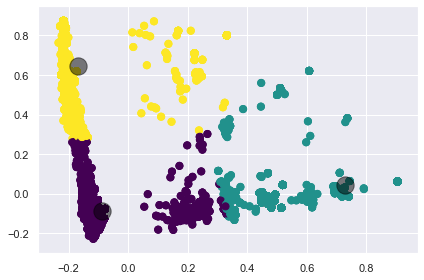

In [18]:
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(tf_idf_array)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto') 
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

skcenters = fitted.cluster_centers_

plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=50, cmap='viridis')
plt.scatter(skcenters[:, 0], skcenters[:, 1], c='black', s=300, alpha=0.5)

plt.tight_layout()

plt.savefig('images/scatter.png', dpi=300)

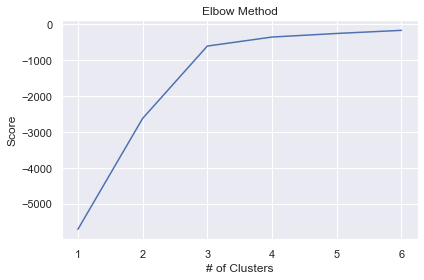

In [19]:
num_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in num_clusters]
kmeans

score = [kmeans[i].fit(Y_sklearn).score(Y_sklearn) for i in range(len(kmeans))]
score

plt.plot(num_clusters, score)
plt.xlabel('# of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')

plt.tight_layout()

plt.savefig('images/elbow.png', dpi=300)

plt.show()

## Highest Mean (tf_idf) Words in Each Cluster

Short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [20]:
def get_top_feats_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) 
        x_means = np.mean(tf_idf_array[id_temp], axis = 0)
        sorted_means = np.argsort(x_means)[::-1][:n_feats]
        feats = tf_idf_vect.get_feature_names()
        best_feats = [(feats[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_feats, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

dfs = get_top_feats_cluster(tf_idf_array, prediction, 15)

### Cluster 1 

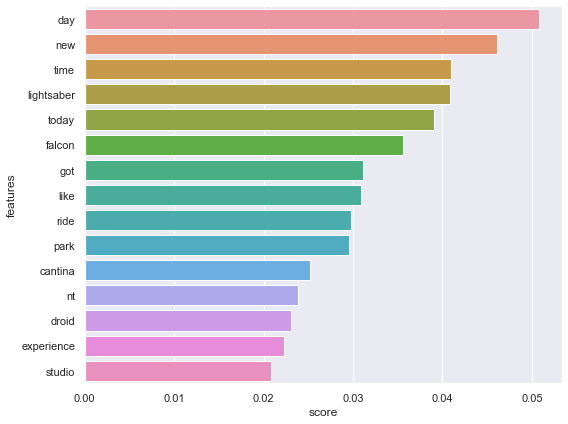

In [21]:
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=dfs[0][:15]);

plt.tight_layout()

plt.savefig('images/cluster1.png', dpi=300)

### Cluster 2

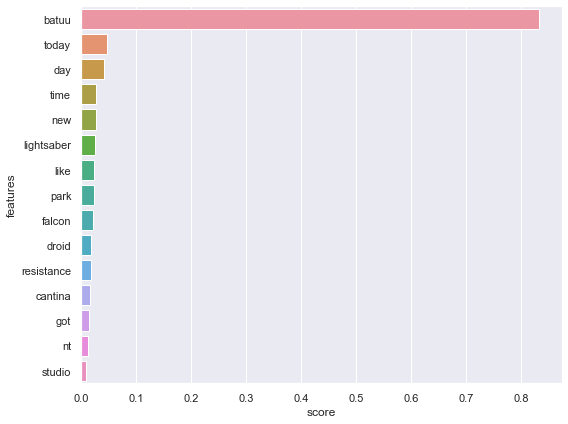

In [22]:
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=dfs[1][:15]);

plt.tight_layout()

plt.savefig('images/cluster2.png', dpi=300)

### Cluster 3

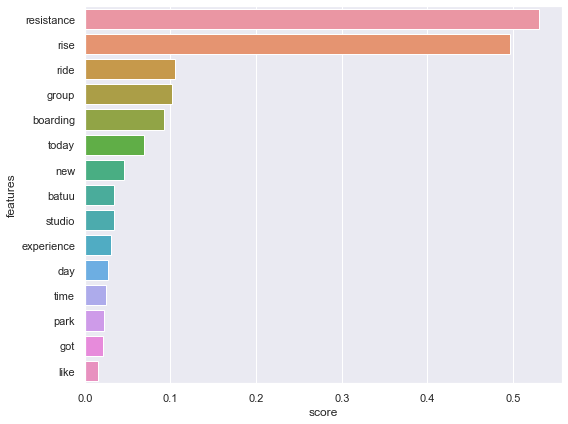

In [23]:
plt.figure(figsize=(8,6))
sns.barplot(x='score', y='features',data=dfs[2][:15]);

plt.tight_layout()

plt.savefig('images/cluster3.png', dpi=300)

# Top Words from Each Cluster

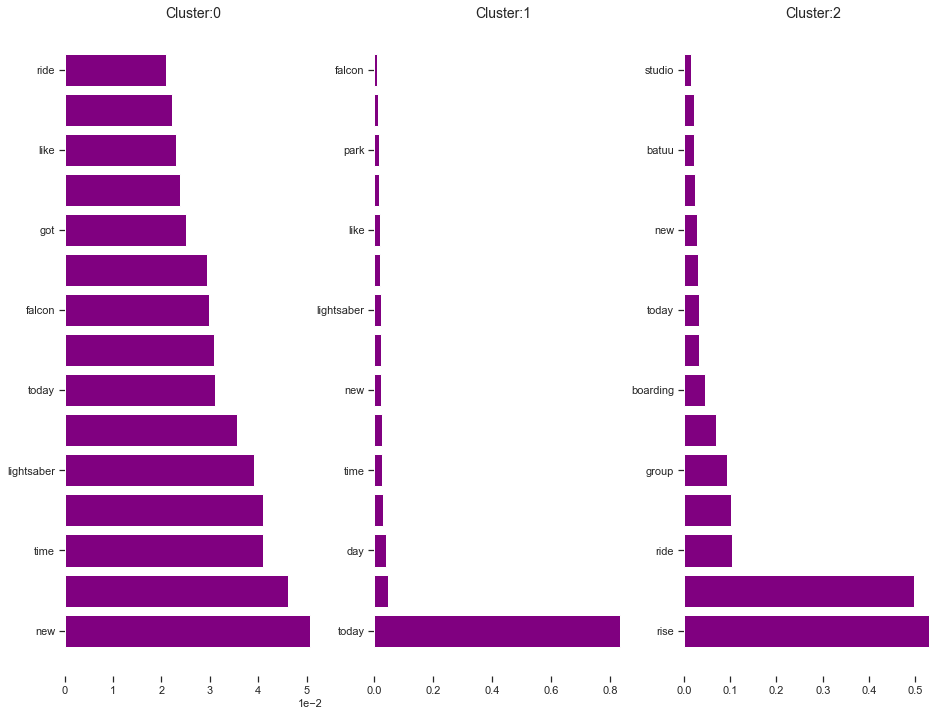

<Figure size 432x288 with 0 Axes>

In [24]:
def plot_features(dfs):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.set_title('Cluster:' + str(i), fontsize=14)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='purple')
        yticks = ax.set_yticklabels(df.features)
    plt.show();
plot_features(dfs)

plt.tight_layout()

plt.savefig('images/top_features.png', dpi=300)